In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip cache purge

Files removed: 2946


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
import transformers
from sklearn import datasets
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report, roc_auc_score
from transformers import DistilBertTokenizer, TFDistilBertForSequenceClassification

In [4]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data/data_cleaned.csv')

In [5]:
#df=df[:10]

In [6]:
df.head()

,Cleaned_Reviews,Pseudo_Labels
0,pro pair switch well multiple device android p...,positive
1,sound quality okay price light comfortable sma...,negative
2,easy operate good product quality satisfied,positive
3,hoping blow head still attached pretty quiet e...,positive
4,despite apple airpods earbuds trick responsive...,positive


In [7]:
df['Pseudo_Labels'].value_counts()

,count
Pseudo_Labels,
positive,13114
negative,3468
neutral,113


label encode

In [8]:
label_map = {'positive': 2, 'neutral': 1, 'negative': 0}
df['Pseudo_Labels'] = df['Pseudo_Labels'].map(label_map)

train/test split with same ratio of classes

In [9]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in sss.split(df, df['Pseudo_Labels']):
    train_df = df.iloc[train_index]
    test_df = df.iloc[test_index]
print(f"Train size: {len(train_df)}, Test size: {len(test_df)}")

Train size: 13356, Test size: 3339


Stratified Split Train into train/validation sets

In [10]:
sss_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)  # 20% of train for validation
for train_index, val_index in sss_val.split(train_df, train_df['Pseudo_Labels']):
    train_split_df = train_df.iloc[train_index]
    val_df = train_df.iloc[val_index]
print(f"Training size: {len(train_split_df)}, Validation size: {len(val_df)}")

Training size: 10684, Validation size: 2672


tokenize train and test data

In [11]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def tokenize_function(reviews):
    return tokenizer(reviews, padding=True, truncation=True, return_tensors="tf")

train_encodings = tokenize_function(train_split_df['Cleaned_Reviews'].tolist())
val_encodings = tokenize_function(val_df['Cleaned_Reviews'].tolist())
test_encodings = tokenize_function(test_df['Cleaned_Reviews'].tolist())

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


create tf datasets

In [12]:
BATCH_SIZE = 16
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    train_split_df['Pseudo_Labels'].values
)).shuffle(10000).batch(BATCH_SIZE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    dict(val_encodings),
    val_df['Pseudo_Labels'].values
)).batch(BATCH_SIZE)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    test_df['Pseudo_Labels'].values
)).batch(BATCH_SIZE)

compile DistilBERT model

In [13]:
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=3)

# Step 8: Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

train model

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
history = model.fit(train_dataset,
                    validation_data=val_dataset,
                    epochs=10,
                    callbacks=[early_stopping])

Epoch 1/10
668/668 [==============================] - 646s 932ms/step - loss: 0.3430 - accuracy: 0.8633 - val_loss: 0.2650 - val_accuracy: 0.9053
Epoch 2/10
668/668 [==============================] - 621s 930ms/step - loss: 0.1846 - accuracy: 0.9351 - val_loss: 0.2335 - val_accuracy: 0.9188
Epoch 3/10
668/668 [==============================] - 653s 977ms/step - loss: 0.0960 - accuracy: 0.9700 - val_loss: 0.2358 - val_accuracy: 0.9150
Epoch 4/10
668/668 [==============================] - 622s 931ms/step - loss: 0.0506 - accuracy: 0.9854 - val_loss: 0.4014 - val_accuracy: 0.9038


evaluate on test dataset

In [15]:
eval_loss, eval_acc = model.evaluate(test_dataset)
print(f"Validation Accuracy: {eval_acc}")

209/209 [==============================] - 64s 304ms/step - loss: 0.2370 - accuracy: 0.9185
Validation Accuracy: 0.918538510799408


predictions

In [16]:
predictions_logits = model.predict(test_dataset)  # Get predictions
predictions = np.argmax(predictions_logits.logits, axis=1)  # Get the predicted class indices
true_labels = test_df['Pseudo_Labels'].values  # True labels from the test dataset

209/209 [==============================] - 65s 303ms/step


In [17]:
report = classification_report(true_labels, predictions, target_names=['negative', 'neutral', 'positive'])
print(report)

              precision    recall  f1-score   support

    negative       0.82      0.79      0.80       693
     neutral       0.60      0.26      0.36        23
    positive       0.94      0.96      0.95      2623

    accuracy                           0.92      3339
   macro avg       0.79      0.67      0.71      3339
weighted avg       0.92      0.92      0.92      3339



In [18]:
probabilities = tf.nn.softmax(predictions_logits.logits, axis=-1).numpy()
# Calculate AUROC for each class
auroc = roc_auc_score(true_labels, probabilities, multi_class='ovr')
print(f"AUROC: {auroc}")

AUROC: 0.9453270012163296


**Precison_Recall curve**

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

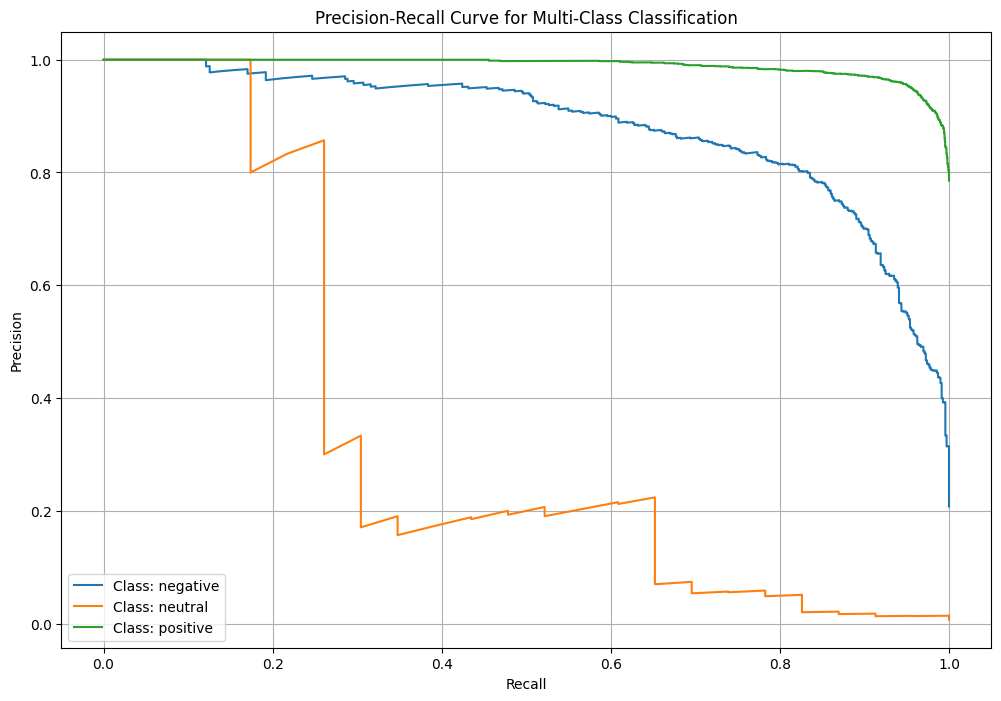

In [23]:
class_names = ['negative', 'neutral', 'positive']
num_classes = len(class_names)

# Plot Precision-Recall curve for each class
plt.figure(figsize=(12, 8))

for i in range(num_classes):
    # Create binary labels for the current class
    true_binary_labels = (true_labels == i).astype(int)

    # Get predicted probabilities for the current class
    class_probabilities = probabilities[:, i]

    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(true_binary_labels, class_probabilities)

    # Plot the precision-recall curve
    plt.plot(recall, precision, label=f'Class: {class_names[i]}')

# Add labels and legend
plt.title('Precision-Recall Curve for Multi-Class Classification')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.grid(True)
plt.legend(loc='best')
plt.show()

In [24]:
model.save_pretrained('distilbert_sentiment_model')
tokenizer.save_pretrained('distilbert_sentiment_model')

('distilbert_sentiment_model/tokenizer_config.json',
 'distilbert_sentiment_model/special_tokens_map.json',
 'distilbert_sentiment_model/vocab.txt',
 'distilbert_sentiment_model/added_tokens.json')